# Machine learning to predict new crescent moon visibility

## Imports

In [190]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #Issue with xgboost & new pandas version
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from astropy.time import Time
import cartopy.crs as ccrs

# MACHINE LEARNING IMPORTS
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

## Options and setup

In [191]:
#METHOD = False # replace seen column with method seen column
MULTI_OUTPUT_METHOD = False #Replace naked eye seen column with array of methods
MULTI_LABEL_METHOD = False #Replace naked eye seen column with either seen, visual aid or not seen
XGBOOST = True #Use xgboost forest or random forest
RANDOM = False # replace data with random arrays
CLOUDCUT = False # cut all complete cloud cover data points
LINUX = True #Use linux file paths
USE_GPU = True #Use a GPU

TITLE = f"{'XGBoost' if XGBOOST else 'Random Forest'} {'Eye' if not MULTI_LABEL_METHOD and not MULTI_OUTPUT_METHOD else ''}{'Multi-label' if MULTI_LABEL_METHOD else ''}{'Multi-output' if MULTI_OUTPUT_METHOD else ''} visibility"

## Hyperparameters

In [192]:
if XGBOOST:
    if MULTI_OUTPUT_METHOD:
        PARAMS = {'learning_rate': 0.1733, 'max_depth': 6, 'n_estimators': 50}
    elif MULTI_LABEL_METHOD:
        PARAMS = {'learning_rate': 0.4183, 'max_depth': 2, 'n_estimators': 100}
    else:
         PARAMS = {'learning_rate': 0.55, 'max_depth': 3, 'n_estimators': 110}
         
else: #Random forest
    if MULTI_OUTPUT_METHOD:
        PARAMS = {}
    elif MULTI_LABEL_METHOD:
        PARAMS = {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 50}
    else:
         PARAMS = {'max_depth': 12, 'n_estimators': 150}

## Reading in data

In [193]:
icouk_data_file = '..\\Data\\icouk_sighting_data_with_params.csv'
icop_data_file = '..\\Data\\icop_ahmed_2020_sighting_data_with_params.csv'
alrefay_data_file = '..\\Data\\alrefay_2018_sighting_data_with_params.csv'
allawi_data_file = '..\\Data\\schaefer_odeh_allawi_2022_sighting_data_with_params.csv'
yallop_data_file = '..\\Data\\Data\\yallop_sighting_data_with_params.csv'

if LINUX:
    icouk_data_file = '../Data/icouk_sighting_data_with_params.csv'
    icop_data_file = '../Data/icop_ahmed_2020_sighting_data_with_params.csv'
    alrefay_data_file = '../Data/alrefay_2018_sighting_data_with_params.csv'
    allawi_data_file = '../Data/schaefer_odeh_allawi_2022_sighting_data_with_params.csv'
    yallop_data_file = '../Data/yallop_sighting_data_with_params.csv'

icouk_data = pd.read_csv(icouk_data_file)
icop_data = pd.read_csv(icop_data_file)
alrefay_data = pd.read_csv(alrefay_data_file)
allawi_data = pd.read_csv(allawi_data_file)
yallop_data = pd.read_csv(yallop_data_file)


data = pd.concat([icouk_data,icop_data,alrefay_data,yallop_data])

print(f"Loaded {data.shape[0]} rows")

#Drop index, dependent parameters (q value etc) and visibility scale
VARS_TO_DROP = ["Index","Date", "Longitude", "Lag","Latitude","q","W","q'","W'","Sunset","Moonset"]
data = data.drop(VARS_TO_DROP+["Visibility","Source","Cloud Level"], axis = 1)

if MULTI_OUTPUT_METHOD:
    data = data.drop(["Seen", "Method"], axis = 1) # replaced by methods column

    ptype = ["Seen_eye", "Seen_binoculars", "Seen_telescope", "Seen_ccd","Not_seen"]

elif MULTI_LABEL_METHOD:
    data = data.drop(["Seen", "Methods"], axis = 1) # replaced by method column
    data["Method"] = data["Method"].replace("Seen_binoculars", "Seen_with_aid")
    data["Method"] = data["Method"].replace("Seen_telescope", "Seen_with_aid")
    data["Method"] = data["Method"].replace("Seen_ccd", "Seen_with_aid")

    ptype = ["Seen_eye", "Seen_with_aid", "Not_seen"]

else:
    data = data[data["Method"] !="Seen_binoculars"] #DROP BINOCULARS
    data = data[data["Method"] !="Seen_ccd"] #DROP CCD
    data = data[data["Method"] !="Seen_telescope"] #DROP TELESCOPE
    
    data=data.drop(['Method','Methods'], axis = 1) #Only use seen

    ptype = ["Seen", "Not_seen"]

if RANDOM:
    data.insert(1,"Random1",np.random.rand(data.shape[0],1))
    data.insert(2,"Random2",np.random.rand(data.shape[0],1))
    data = data[['Seen', "Random1","Random2"]]

if CLOUDCUT:
    data = data[data["Cloud Level"] <= 0.5]
    #data = data[data["Cloud Level"] == 0]

print(f"Using {data.shape[0]} rows")

Loaded 3555 rows
Using 3101 rows


## Visualising variables

## ML Training

In [194]:
# List of features without label feature
variable_list =  data.columns.tolist()
features = variable_list


if MULTI_OUTPUT_METHOD:
    orig_y = np.array(data['Methods'].str.split(";"))
    mlb = MultiLabelBinarizer(classes=ptype)
    y = mlb.fit_transform(orig_y)
    features.remove('Methods')
    # test = pd.DataFrame(y, columns=mlb.classes_)
    # print(test.head(10))

elif MULTI_LABEL_METHOD:
    data["Method"] = data["Method"].replace("Seen_eye",2) #XGboost needs 1 and 0
    data["Method"] = data["Method"].replace("Seen_with_aid",1)
    data["Method"] = data["Method"].replace("Not_seen",0)
    y = np.array(data['Method'])
    features.remove('Method')
    
else:
    if XGBOOST:
        data["Seen"] = data["Seen"].replace("Seen",1) #XGboost needs 1 and 0
        data["Seen"] = data["Seen"].replace("Not_seen", 0)
    y = np.array(data['Seen'])
    features.remove('Seen')
    pos = 'Seen' # for ROC curve +ve result

X = data[features]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80/20 training/test split

In [195]:
# Produce randomforest classifier model and fit to training data
def select_model():
    if XGBOOST:
        if MULTI_OUTPUT_METHOD:
            if USE_GPU:
                method = "gpu_hist"
            else:
                method = "hist"
            model = XGBClassifier(tree_method=method, n_jobs=-1)
        else:
            model = XGBClassifier(n_jobs=-1)
    else:
        if MULTI_OUTPUT_METHOD:
            model = MultiOutputClassifier(RandomForestClassifier(n_jobs=-1))
        else:
            model = RandomForestClassifier(n_jobs=-1)

    model = model.set_params(**PARAMS)
    return model
model = select_model()
# Fitting takes the input and "truth" data for classification purposes
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.55, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=110, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [196]:
def get_easiest_method_array(methods):
    easiest_methods = np.zeros(methods.shape)
    easiest_methods[np.arange(0,methods.shape[0],1),np.argmax(methods,axis=1)] = 1
    return easiest_methods

def get_easiest_method_names(methods):
    easiest_methods = get_easiest_method_array(methods)
    return mlb.inverse_transform(easiest_methods.astype(int))

# Produce predictions for the classification of your training dataset using your model:
y_pred = model.predict(x_train)

# plot the accuracies of said predictions
print("Accuracy on training dataset:",accuracy_score(y_train, y_pred))
rf_acc_train = accuracy_score(y_train, y_pred)
y_pred = model.predict(x_test)

print("Accuracy on testing dataset:", accuracy_score(y_test, y_pred))
rf_acc_test = accuracy_score(y_test, y_pred)

if MULTI_OUTPUT_METHOD:
    print("Accuracy on testing dataset (easiest method only):", accuracy_score(get_easiest_method_names(y_test), get_easiest_method_names(y_pred)))

Accuracy on training dataset: 0.9891129032258065
Accuracy on testing dataset: 0.9033816425120773


## ROC curve

In [197]:
# Get predicted class probabilities for the test set 
if MULTI_OUTPUT_METHOD:
    #y_pred_prob = rf.predict_proba(x_test)
    #roc_auc = roc_auc_score(y_test, y_pred_prob)
    print("Not currently working")
elif MULTI_LABEL_METHOD:
    y_pred_prob = model.predict_proba(x_test)
    roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
    print(f"ROC curve {roc_auc}")
else:
    y_pred_prob = model.predict_proba(x_test)[:, 1] 
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"ROC curve {roc_auc}")

ROC curve 0.9602033475105272


## Generating contour map based on predictions

Y: Seen: 954 Not Seen: 646
ML: Seen: 741 Not Seen: 859
Accuracy (compared to Yallop q values): 86.7%


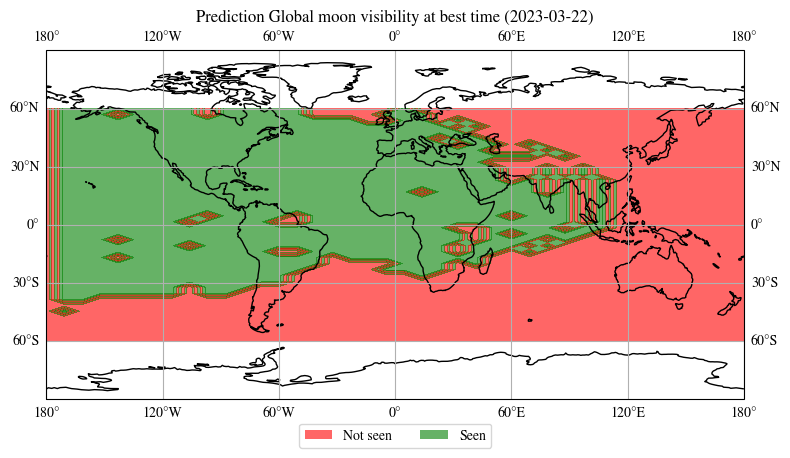

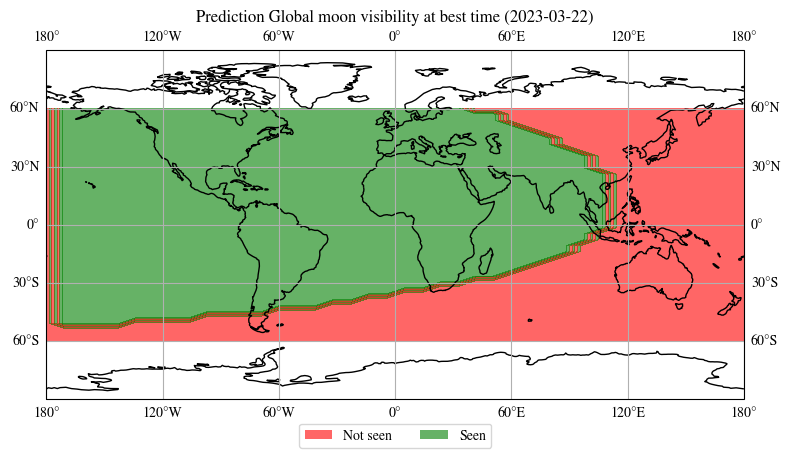

In [198]:
def contour_plot(lat_arr, lon_arr, qvals):
    
    plt.figure(figsize=(9,5))
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'

    x, y = np.meshgrid(lon_arr,lat_arr,indexing='xy')
    sqqvals = np.reshape(qvals,(len(lat_arr),len(lon_arr)))
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    cs = plt.contourf(x, y , sqqvals,alpha=0.6, extend='max',colors=["red","green"])
    
    #plt.colorbar(cs)
    nm = cs.legend_elements()[0]
    lbl = ["Not seen",'Seen']
    plt.legend(nm, lbl, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(lbl))

    if -np.min(lon_arr)+ np.max(lon_arr) ==360:
        plt.ylim(-90,90)
        plt.xlim(-180,180)
    else:
        ax.set_extent((np.min(lon_arr), np.max(lon_arr),np.min(lat_arr), np.max(lat_arr)),crs=ccrs.PlateCarree()) 

    title_date = obs_date.to_datetime().date()
    plt.title(f"Prediction Global moon visibility at best time ({title_date})")
    plt.savefig(f"..\\Graphs\\Prediction Global moon visibility at best time ({title_date}).png",dpi=200)
    plt.show()


def create_contour_plot(obs_date,min_lat, max_lat, min_lon, max_lon, no_of_points):
    file_path = f'..\\Data\\Generated\\{obs_date.to_datetime().date()} LAT {min_lat} {max_lat} LON {min_lon} {max_lon} {no_of_points}x{no_of_points}'
    generated_params = pd.read_csv(file_path+'.csv')

    yallop_prediction = generated_params["Seen"].to_numpy()
    yallop_prediction[yallop_prediction=="S"] = 1
    yallop_prediction[yallop_prediction=="N"] = 0
    yallop_prediction = yallop_prediction.astype(int)

    generated_params = generated_params.drop(VARS_TO_DROP+["q","W","q'","W'","Seen"], axis = 1)
    prediction = model.predict(generated_params)

    if not XGBOOST:
        prediction[prediction=="Seen"] = 1
        prediction[prediction=="Not_seen"] = 0
        prediction = prediction.astype(int)

    print(f"Y: Seen: {yallop_prediction[yallop_prediction==1].shape[0]} Not Seen: {yallop_prediction[yallop_prediction==0].shape[0]}")
    print(f"ML: Seen: {prediction[prediction==1].shape[0]} Not Seen: {prediction[prediction==0].shape[0]}")
    print(f"Accuracy (compared to Yallop q values): {accuracy_score(prediction,yallop_prediction):.1%}")

    #Plots moon visibility across a world map
    lat_arr = np.linspace(min_lat, max_lat, no_of_points)
    lon_arr = np.linspace(min_lon, max_lon, no_of_points)

    contour_plot(lat_arr, lon_arr, prediction)
    
    
    
    generated_params["Seen"] = yallop_prediction
    generated_params["Prediction"] = prediction

    contour_plot(lat_arr, lon_arr, yallop_prediction)
    generated_params.to_csv(file_path+' prediction.csv')


obs_date = Time("2023-03-22")
#obs_date = Time("2023-11-15")
create_contour_plot(obs_date,min_lat=-60, max_lat=60, min_lon=-180, max_lon=180, no_of_points=40)

#create_contour_plot(obs_date,min_lat=48, max_lat=60, min_lon=-8, max_lon=2, no_of_points=40)